# Absa Zindi Income Prediction: SageMaker Inference Pipelines

This notebook is part of a continuation of the **Absa Zindi Challenge - Income Prediction** project. The initial work on this project aimed to predict customer income based on various features, using advanced machine learning techniques to model the data effectively.

In this extended phase, we focus on implementing a **custom Scikit-learn ensemble Random Forest model** instead of XGBoost. The goal is to enhance prediction accuracy and streamline the end-to-end machine learning pipeline using **Amazon SageMaker**. This includes workflows for **model training, hyperparameter optimization**, and **model deployment** to support scalable and robust production environments.

### Key Enhancements:
1. **Data Processing**: Preprocessing the data to ensure it is clean, well-structured, and optimized for Random Forest modeling.
2. **Hyperparameter Optimization (HPO)**: Fine-tuning the Random Forest model’s hyperparameters to achieve the best predictive performance using SageMaker’s HPO capabilities.
3. **Model Evaluation**: Assessing model performance using key metrics such as **Root Mean Squared Error (RMSE)**, tailored to evaluate regression tasks effectively.
4. **Model Registration**: Storing, versioning, and managing the best-performing Random Forest models with SageMaker Model Registry for easy retrieval and deployment.
5. **Model Deployment**: Automating the deployment of the trained model to SageMaker endpoints for real-time inference, as well as batch inference using SageMaker Batch Transform when required.

### Project Objectives:
- **Improve Prediction Accuracy:** Leverage the strengths of the Scikit-learn ensemble Random Forest to capture complex patterns in customer data.
- **Automate the ML Pipeline:** Implement a fully automated workflow covering data preprocessing, model training, evaluation, and deployment.
- **Ensure Scalability:** Utilize SageMaker’s infrastructure to handle large datasets efficiently and support both real-time and batch predictions.
- **Model Monitoring:** Incorporate model monitoring for continuous performance tracking in production environments.

This notebook provides a comprehensive guide on building, optimizing, and deploying machine learning models with Amazon SageMaker, tailored to income prediction based on customer data.


# Import Libraries

In [1]:
import sys
import os
import json
from pprint import pprint

import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession

from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import (
    ProcessingInput, 
    ProcessingOutput, 
    Processor,
    ScriptProcessor
)

from sagemaker.inputs import TrainingInput
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import Model

from sagemaker.sklearn.model import SKLearnModel

from sagemaker.workflow.steps import (
    TuningStep,
    ProcessingStep, 
    CacheConfig,
    TransformStep
)
from sagemaker.tuner import (
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
    HyperparameterTuner,
    WarmStartConfig,
    WarmStartTypes,
)
from sagemaker.transformer import Transformer
from sagemaker.inputs import TransformInput
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join
from sagemaker.workflow.pipeline import Pipeline

from sagemaker.model_metrics import (
    MetricsSource,
    ModelMetrics,
)

from sagemaker.workflow.functions import Join, JsonGet
from sagemaker.workflow.execution_variables import ExecutionVariables


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


# Some Project Variables

In [2]:
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
pipeline_session = PipelineSession()
default_bucket = sagemaker_session.default_bucket()
model_package_group_name = f"absa-zindi-model-group"
project_name = "absa_zindi_challenge" 
s3_project_prefix = f"{project_name}/input-data"
cache_config = CacheConfig(enable_caching=True, expire_after="30d")

In [3]:
print(sagemaker_session)
print(region)
print(role)
print(default_bucket)

us-east-1
arn:aws:iam::770208914484:role/service-role/AmazonSageMaker-ExecutionRole-20241229T183387
sagemaker-us-east-1-770208914484


# Input Data s3 location

In [4]:
train_data_s3_uri = os.path.join("s3://", default_bucket, s3_project_prefix, "train", "Train.csv")
test_data_s3_uri = os.path.join("s3://", default_bucket, s3_project_prefix, "test", "Test.csv")
customer_data_s3_uri = os.path.join("s3://", default_bucket, s3_project_prefix,"customer",  "customer.csv")
transactions_data_s3_uri = os.path.join("s3://", default_bucket, s3_project_prefix, "transactions", "transactions.csv")

# Pipeline Parameters

In this section, the code defines various parameters for an Amazon SageMaker pipeline. These parameters allow users to specify values at runtime, such as the instance count, data sources, and thresholds. These parameters are used in different steps of the pipeline to configure the behavior of each step.

1. **`ParameterInteger`**: 
   - **`processing_instance_count`**: Specifies the number of instances to use for the data processing step. It defaults to `1`, but can be modified at runtime.
   - **Purpose**: Controls how many instances will be used for the processing tasks like data cleaning or transformation.

2. **`ParameterString`**:
   - **`instance_type`**: Defines the type of instance for training (e.g., `ml.m4.xlarge`). This can be changed based on available resources or performance requirements.
   - **`model_approval_status`**: Specifies the model approval status, which is set to `"PendingManualApproval"` by default. This can be modified to `"Approved"` or `"Rejected"` as needed during model deployment.
   - **`train_data`**: The URI of the training data stored in S3. This data is used for training the model.
   - **`test_data`**: The URI of the test data stored in S3. This data is used for evaluating the model's performance.
   - **`customer_data`**: The URI for the customer-related data in S3.
   - **`transactions_data`**: The URI for transaction-related data stored in S3.
   
3. **`ParameterFloat`**:
   - **`rmse_score_threshold`**: A floating-point parameter specifying the threshold for the RMSE (Root Mean Squared Error). If the model's RMSE score is greater than this threshold, it may trigger certain actions like re-training or rejection.

#### Purpose of Each Parameter:
- **`ParameterInteger`**: For integer values like instance counts.
- **`ParameterString`**: For string values like URIs, model approval status, and instance types.
- **`ParameterFloat`**: For numerical values with decimal points, such as thresholds for performance metrics like RMSE.

#### Use Case:
These parameters are critical when running the SageMaker pipeline because they allow users to define the behavior of different pipeline steps without modifying the code itself. Instead, they can modify values such as the data sources or instance types at runtime, making the pipeline more flexible and reusable.

#### Example:
- **Train Data Parameter**: By setting the `train_data` parameter, users can specify which S3 location to use for training without changing the code.
- **RMSE Threshold Parameter**: If users want to adjust the model's performance expectations, they can update the `rmse_score_threshold` parameter to set a different threshold for RMSE values that trigger further steps.




In [5]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
instance_type = ParameterString(name="TrainingInstanceType", default_value='ml.m4.xlarge')

model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)

train_data = ParameterString(
    name="TrainData",
    default_value=train_data_s3_uri
)

test_data = ParameterString(
    name="TestData",
    default_value=test_data_s3_uri
)

customer_data = ParameterString(
    name="CustomerData",
    default_value=customer_data_s3_uri
)

transactions_data = ParameterString(
    name="TransactionsData",
    default_value=transactions_data_s3_uri
)

rmse_score_threshold = ParameterFloat(name="RMSEThreshold", default_value=6500.00)

# Preprocessing Step

## SageMaker Preprocessing Script Overview

This script prepares data for a machine learning model in Amazon SageMaker, focusing on feature engineering, data merging, and dataset splitting.

#### Imports and Logging
- **Libraries:** `pandas`, `numpy`, `sklearn`, `joblib`, `argparse`, `os`, `logging`
- **Logging:** Tracks script execution with `INFO` level logs.

#### Helper Functions

- **`flatten_transactions(df)`**
  - Creates transaction-related features:
    - Flags for transaction types (`IS_CHEQ_TRANS`, `IS_SAVE_TRANS`).
    - Amount calculations (`CHEQ_AMT`, `SAVE_AMT`, `INBOUND_AMT`, `OUTBOUND_AMT`).
    - Channel flags (`IS_SYSTEM_CHANNEL`, `IS_ATM_CHANNEL`, etc.).
    - Transaction descriptions (`IS_POS_TRANS`, `IS_ATM_WITHDRAW_TRANS`, etc.).
  - Aggregates data by `CUSTOMER_IDENTIFIER` and `RECORD_MONTH`:
    - Counts transactions, calculates mean, max, min, median, standard deviation, and 90th percentile for balances and transaction amounts.
  - Further aggregates at the customer level using:
    - Mean, min, max, median, standard deviation, and 75th percentile.

- **`remove_correlated_features(df, threshold=0.9)`**
  - Identifies highly correlated features using the correlation matrix.
  - Removes one feature from each pair with a correlation above 0.9 to reduce multicollinearity.

- **`merge_and_flatted_trans_agg(df)`**
  - Merges the input dataframe with:
    - `customer_df` (customer-level information).
    - `transactions_df` (flattened transaction features).
  - Fills missing values with zeros and sets the index using `CUSTOMER_IDENTIFIER`, `RECORD_DATE`, and `DATE_LAST_UPDATED`.

#### Main Script Logic

1. **Argument Parsing:**
   - Accepts `--train-size` (default: 0.8) and `--random-state` (default: 0) for data splitting control.

2. **Data Loading:**
   - Reads input data from `/opt/ml/processing/input`:
     - `Train.csv`, `Test.csv`, `customer.csv`, `transactions.csv`.
   - Processes `transactions_df`:
     - Converts `RECORD_DATE` to datetime and extracts `RECORD_MONTH`.
     - Applies `flatten_transactions()` and `remove_correlated_features()`.

3. **Data Merging:**
   - Merges `train_df` and `test_df` with customer and transaction data using `merge_and_flatted_trans_agg()`.

4. **Train-Test Split:**
   - Splits `train_df` into training (80%) and testing (20%) datasets.
   - Further splits the training set into training (85%) and validation (15%) subsets.

5. **Feature Selection with RFE (Recursive Feature Elimination):**
   - Uses `RandomForestRegressor` with `RFECV` for feature selection.
   - Selects features based on 5-fold cross-validation using negative RMSE as the scoring metric.

6. **Saving Processed Data:**
   - Writes processed datasets to `/opt/ml/processing/output`:
     - Training, validation, testing datasets in CSV format (without headers and indices).
     - A `to_be_submitted.csv` file for submission purposes.

7. **Logging Final Information:**
   - Logs the remaining columns after feature selection.
   - Logs the sizes of the training, validation, test, and submission datasets.

#### Key Outputs
- **Processed Datasets:**
  - `train.csv`, `validation.csv`, `test.csv`, `to_be_submitted.csv`
- **Logs:**
  - Feature selection details, dataset sizes, and confirmation of script completion.


In [6]:
%%writefile code/preprocessing.py
import os
import argparse
import logging
import joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestRegressor

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

def flatten_transactions(df):
    # creating helper columns
    df["IS_CHEQ_TRANS"] = np.where(df.PRODUCT_CODE == "CHEQ", 1, 0)
    df["IS_SAVE_TRANS"] = np.where(df.PRODUCT_CODE == "SAVE", 1, 0)
    df["CHEQ_AMT"] = df.loc[df.PRODUCT_CODE == "CHEQ", "AMT"]
    df["SAVE_AMT"] = df.loc[df.PRODUCT_CODE == "SAVE", "AMT"]
    df["INBOUND_AMT"] = df.loc[df.AMT>0, "AMT"]
    df["OUTBOUND_AMT"] = df.loc[df.AMT<0, "AMT"]
    df["CHEQ_INBOUND_AMT"] = df.loc[(df.PRODUCT_CODE == "CHEQ") & (df.AMT>0), "AMT"]
    df["SAVE_INBOUND_AMT"] = df.loc[(df.PRODUCT_CODE == "SAVE") & (df.AMT>0), "AMT"]
    df["CHEQ_OUTBOUND_AMT"] = np.abs(df.loc[(df.PRODUCT_CODE == "CHEQ") & (df.AMT<0), "AMT"])
    df["SAVE_OUTBOUND_AMT"] = np.abs(df.loc[(df.PRODUCT_CODE == "SAVE") & (df.AMT<0), "AMT"])
    
    df["IS_SYSTEM_CHANNEL"] = np.where(df.CHANNEL == "system", 1, 0)
    df["IS_ATM_CHANNEL"] = np.where(df.CHANNEL == "atm", 1, 0)
    df["IS_INTERNET_CHANNEL"] = np.where(df.CHANNEL == "internet", 1, 0)
    df["IS_TELLER_CHANNEL"] = np.where(df.CHANNEL == "teller", 1, 0)
    
    df["CHEQ_ACCOUNT_BALANCE"] = df.loc[df.PRODUCT_CODE == "CHEQ", "ACCOUNT_BALANCE"]
    df["SAVE_ACCOUNT_BALANCE"] = df.loc[df.PRODUCT_CODE == "SAVE", "ACCOUNT_BALANCE"]
    
    df["IS_POS_TRANS"] =np.where(df.TRANSACTION_DESCRIPTION == "POS PURCHASE",1,0)
    df["IS_ATM_WITHDRAW_TRANS"] =np.where(df.TRANSACTION_DESCRIPTION == "ATM WITHDRAWAL",1,0)
    df["IS_AIRTIME_DEBIT_TRANS"] =np.where(df.TRANSACTION_DESCRIPTION == "AIRTIME DEBIT",1,0)

    trans_per_cust_per_month_df = (
        df
        .groupby(["CUSTOMER_IDENTIFIER", "RECORD_MONTH"])
        .agg(CNT_TRNS = ("EVENT_NUMBER", "count"),
             AVG_ACC_BAL = ("ACCOUNT_BALANCE", "mean"),
             MAX_ACC_BAL =  ("ACCOUNT_BALANCE", "max"),
             MIN_ACC_BAL =  ("ACCOUNT_BALANCE", "min"),
             MEDIAN_ACC_BAL =  ("ACCOUNT_BALANCE", "median"),
             STDDEV_ACC_BAL =  ("ACCOUNT_BALANCE", "std"),
             NINETIENT_ACC_BAL = ('ACCOUNT_BALANCE', lambda x: x.quantile(0.9)),
             AVG_INBOUND_AMT = ("INBOUND_AMT", "mean"),
             MAX_INBOUND_AMT =  ("INBOUND_AMT", "max"),
             MIN_INBOUND_AMT =  ("INBOUND_AMT", "min"),
             MEDIAN_INBOUND_AMT =  ("INBOUND_AMT", "median"),
             STDDEV_INBOUND_AMT =  ("INBOUND_AMT", "std"),
             NINETIENT_INBOUND_AMT = ("INBOUND_AMT", lambda x: x.quantile(0.9)),
             TOTAL_INBOUND_AMT = ("INBOUND_AMT", "sum"),
             AVG_OUTBOUND_AMT = ("OUTBOUND_AMT", "mean"),
             MAX_OUTBOUND_AMT =  ("OUTBOUND_AMT", "max"),
             MIN_OUTBOUND_AMT =  ("OUTBOUND_AMT", "min"),
             MEDIAN_OUTBOUND_AMT =  ("OUTBOUND_AMT", "median"),
             STDDEV_OUTBOUND_AMT =  ("OUTBOUND_AMT", "std"),
             NINETIENT_OUTBOUND_AMT = ("OUTBOUND_AMT", lambda x: x.quantile(0.9)),
             TOTAL_OUTBOUND_AMT = ("OUTBOUND_AMT", "sum"),
             CNT_CHEQ_TRANS = ("IS_CHEQ_TRANS", "sum"),
             CNT_SAVE_TRANS = ("IS_SAVE_TRANS", "sum"),
             CHEQ_INBOUND_AMT  = ("CHEQ_INBOUND_AMT", "sum"),
             SAVE_INBOUND_AMT  = ("SAVE_INBOUND_AMT", "sum"),
             CHEQ_OUTBOUND_AMT  = ("CHEQ_OUTBOUND_AMT", "sum"),
             SAVE_OUTBOUND_AMT  = ("SAVE_OUTBOUND_AMT", "sum"),
             CNT_SYS_TRNS = ("IS_SYSTEM_CHANNEL", "sum"),
             CNT_ATM_TRNS = ("IS_ATM_CHANNEL", "sum"),
             CNT_INTERNET_TRNS  = ("IS_INTERNET_CHANNEL", "sum"),
             CNT_TELLER_TRNS = ("IS_TELLER_CHANNEL", "sum"),
             AVG_CHEQ_ACC_BAL  = ("CHEQ_ACCOUNT_BALANCE", "mean"),
             AVG_SAVE_ACC_BAL  = ("SAVE_ACCOUNT_BALANCE", "mean"),
             MAX_CHEQ_ACC_BAL  = ("CHEQ_ACCOUNT_BALANCE", "max"),
             MAX_SAVE_ACC_BAL  = ("SAVE_ACCOUNT_BALANCE", "max"),
             MEDIAN_CHEQ_ACC_BAL  = ("CHEQ_ACCOUNT_BALANCE", "median"),
             MEDIAN_SAVE_ACC_BAL  = ("SAVE_ACCOUNT_BALANCE", "median"),
             CNT_POS_TRNS  = ("IS_POS_TRANS", "sum"),
             CNT_ATM_WITHDRAW_TRNS  = ("IS_ATM_WITHDRAW_TRANS", "sum"),
             CNT_AIRTIME_DEBIT_TRNS  = ("IS_AIRTIME_DEBIT_TRANS", "sum"),
             
            )
    ).reset_index()
    
    agg_funcs = ['mean', 'min', 'max', 'median', 'std', lambda x: x.quantile(0.75)]
    
    # Perform the groupby operation
    flat_trans_df = (
        trans_per_cust_per_month_df
        .groupby('CUSTOMER_IDENTIFIER')
        [trans_per_cust_per_month_df.columns[2:]]
        .agg(agg_funcs)
    )
    # Rename the last column (75th percentile)
    flat_trans_df.columns = ['_'.join(col).upper() if isinstance(col, tuple) else col for col in flat_trans_df.columns]
    flat_trans_df = flat_trans_df.rename(
        columns={col: col.replace('<LAMBDA_0>', '75TH_PERC') for col in flat_trans_df.columns}
    ).reset_index()
    return flat_trans_df

def remove_correlated_features(df, threshold=0.9):
    corr_matrix = df.iloc[:, 1:].corr().abs()  # Use absolute values to check strength of correlation
    # Identify highly correlated features
    to_drop = set()  # Set to store columns to drop
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # Avoid diagonal and duplicate pairs
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[j]  # Select the second variable in the pair
                to_drop.add(colname)
    logger.info(f"Highly correlated features removed {to_drop}")
    return df.drop(columns=to_drop)
    
def merge_and_flatted_trans_agg(df):
    out_df = df.merge(customer_df, on='CUSTOMER_IDENTIFIER')
    out_df = out_df.merge(transactions_df, on="CUSTOMER_IDENTIFIER")
    return out_df.set_index(["CUSTOMER_IDENTIFIER", "RECORD_DATE", "DATE_LAST_UPDATED"]).fillna(0)

if __name__=="__main__":
    logger.info("Loading arguments")
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-size", type=float, default=0.8)
    parser.add_argument("--random-state", type=int, default=0)
    args, _ = parser.parse_known_args()
    
    base_dir = "/opt/ml/processing"
    train_df = pd.read_csv(os.path.join(base_dir, "input","train", "Train.csv"), thousands=r',')
    test_df = pd.read_csv(os.path.join(base_dir, "input","test", "Test.csv"))
    customer_df = pd.read_csv(os.path.join(base_dir, "input","customer", "customer.csv"))
    transactions_df = pd.read_csv(os.path.join(base_dir, "input","transactions", "transactions.csv"))
    transactions_df['RECORD_DATE'] = pd.to_datetime(transactions_df['RECORD_DATE'])
    transactions_df['RECORD_MONTH']  = transactions_df['RECORD_DATE'].dt.to_period('M')
    transactions_df = remove_correlated_features(flatten_transactions(transactions_df))
    
    train_df = merge_and_flatted_trans_agg(train_df)
    to_be_submitted_df = merge_and_flatted_trans_agg(test_df)
    
    train, test = train_test_split(train_df, train_size=float(args.train_size), random_state=int(args.random_state))
    train, val = train_test_split(train, train_size=0.85, random_state=int(args.random_state))

    y = train["DECLARED_NET_INCOME"]
    X = train.iloc[:,1:]
    logger.info("Initiating RFE...")
    rf = RandomForestRegressor(random_state=345)
    selector = RFECV(rf, step=1, cv=5, scoring="neg_root_mean_squared_error")
    selector = selector.fit(X, y)
    train = pd.concat([y, X.loc[:,selector.support_]], axis=1)
    remaining_cols = list(train.columns)
    logger.info(f"columns after RFE {remaining_cols}")
    logger.info(f"Train size : {train.shape[0]}")
    logger.info(f"Validation size : {val.shape[0]}")
    logger.info(f"Test size : {test.shape[0]}")
    logger.info(f"Tp be submitted size : {len(to_be_submitted_df)}")
    pd.DataFrame(train).to_csv(
        f"{base_dir}/output/train/train.csv",
        header=False, 
        index=False
    )
    pd.DataFrame(val)[remaining_cols].to_csv(
        f"{base_dir}/output/validation/validation.csv",  
        header=False, 
        index=False
    )
    pd.DataFrame(test)[remaining_cols].to_csv(
        f"{base_dir}/output/test/test.csv",  
        header=False, 
        index=False
    )
    remaining_cols.remove("DECLARED_NET_INCOME")
    to_be_submitted_df[remaining_cols].to_csv(
        f"{base_dir}/output/to_be_submitted/to_be_submitted.csv",  
        # header=False,
        # index=False
    )
    logger.info("Processing job complete!") 

Overwriting code/preprocessing.py


### SageMaker SKLearnProcessor Configuration

This configuration sets up a SageMaker `SKLearnProcessor` for data preprocessing, a critical step in any machine learning pipeline. Preprocessing ensures that the raw data is clean, well-structured, and ready for model training, directly impacting the model's accuracy and performance.

#### Processor
---------------
The `SKLearnProcessor` is initialized with the following parameters:
- **Framework Version:** `1.2-1` – Ensures compatibility with specific scikit-learn features.
- **Instance Type:** `ml.t3.large` – Balances cost and performance for moderate data processing tasks.
- **Instance Count:** `processing_instance_count` – Scales processing based on workload.
- **Base Job Name:** `"sklearn-absa-zindi-process"` – Provides consistent job naming for easier tracking.
- **Role:** `role` – Grants the necessary permissions for SageMaker to access resources securely.
- **Session:** `pipeline_session` – Integrates with SageMaker Pipelines for streamlined workflows.

#### Inputs
-------------

Data inputs are essential for feeding raw datasets into the processing job:
- **Train Data:** `/opt/ml/processing/input/train` – The primary dataset for model learning.
- **Test Data:** `/opt/ml/processing/input/test` – Used to evaluate model performance post-training.
- **Transactions Data:** `/opt/ml/processing/input/transactions` – Adds transactional context to the model.
- **Customer Data:** `/opt/ml/processing/input/customer` – Enhances feature engineering with customer details.

#### Outputs
------------
Processed outputs are stored in Amazon S3 for downstream tasks:
- **Train Data:** Preprocessed data for model training.
- **Validation Data:** Used to fine-tune model hyperparameters.
- **Test Data:** Final dataset to assess model generalization.
- **Submission File:** Data formatted for competition or business submission requirements.
- **Artifacts:** Stores metadata, logs, or other relevant processing artifacts.

#### Processing Script
-----------------
- **Script:** `code/preprocessing.py` – Automates data cleaning, feature engineering, and transformation,
- **Arguments:**
  - `--train-size 0.9` – Allocates 90% of data for training, optimizing learning while leaving enough for validation.
  - `--random_state 100` – Ensures reproducibility of results for consistent model evaluation.


In [7]:
framework_version = "1.2-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type='ml.t3.large',
    instance_count=processing_instance_count,
    base_job_name="sklearn-absa-zindi-process",
    role=role,
    sagemaker_session=pipeline_session,
)

processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=train_data_s3_uri, destination="/opt/ml/processing/input/train"),
        ProcessingInput(source=test_data_s3_uri, destination="/opt/ml/processing/input/test"),
        ProcessingInput(source=transactions_data_s3_uri, destination="/opt/ml/processing/input/transactions"),
        ProcessingInput(source=customer_data_s3_uri, destination="/opt/ml/processing/input/customer")
    ],
    outputs=[
        ProcessingOutput(
            output_name="train",
            source="/opt/ml/processing/output/train",
            destination = f"s3://{default_bucket}/{project_name}/opt/ml/processing/output/train"
                        ),
        
        ProcessingOutput(
            output_name="validation",
            source="/opt/ml/processing/output/validation",
            destination = f"s3://{default_bucket}/{project_name}/opt/ml/processing/output/validation"),
        ProcessingOutput(
            output_name="test",
            source="/opt/ml/processing/output/test",
            destination = f"s3://{default_bucket}/{project_name}/opt/ml/processing/output/test"
        ),
        ProcessingOutput(
            output_name="to_be_submitted",
            source="/opt/ml/processing/output/to_be_submitted",
            destination = f"s3://{default_bucket}/{project_name}/opt/ml/processing/output/to_be_submitted"
        ),
        ProcessingOutput(
            output_name="artifacts",
            source="/opt/ml/processing/output/artifacts",
            destination = f"s3://{default_bucket}/{project_name}/opt/ml/processing/output/artifacts"
        )
    ],
    code="code/preprocessing.py",
    arguments=[
        "--train-size" ,'0.9',
        "--random_state", '100'])
step_process = ProcessingStep(name="AbsaZindiProcess", step_args=processor_args)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


# Tuning Step

### Code Explanation: `train.py`

#### Imports and Setup
-------------------------------
   The script begins by importing necessary libraries:
   - `argparse`: To handle command-line arguments.
   - `joblib`: For saving and loading the trained model.
   - `os`: To interact with the operating system (e.g., file paths).
   - `logging`: To record the progress and status of the script.
   - `numpy` and `pandas`: For numerical and data manipulation.
   - `RandomForestRegressor` and `mean_squared_error` from `sklearn`: For building and evaluating a machine learning model (Random Forest Regressor).

   The logger is set up to output information to the console.

#### Argument Parsing
-------
   The script uses `argparse` to parse several command-line arguments:
   - `--model-dir`: Directory to save the trained model.
   - `--train`: Directory for the training data.
   - `--validation`: Directory for the validation data.
   - `--n_estimators`: Number of trees in the Random Forest.
   - `--max_depth`: Maximum depth of the trees.
   - `--min_samples_split`: Minimum number of samples required to split a node.
   - `--min_samples_leaf`: Minimum number of samples required in a leaf.
   - `--max_features`: Number of features to consider when looking for the best split.

   These arguments can either be passed through the command line or be retrieved from environment variables if not provided explicitly.
   
#### Loading Data
---------
   The script logs the start of the data extraction process. It then loads the training and validation datasets using `pandas.read_csv()`. The CSV files are expected to be in the directories provided by the `--train` and `--validation` arguments.

   - `train_df`: Training data (features and target values).
   - `validation_df`: Validation data (features and target values).

   The `header=None` parameter assumes that the datasets do not have headers.

#### Preprocessing Data
-------
   - The features (`X_train` and `X_val`) are extracted from the datasets, which are all columns except the first one (the target variable).
   - The target variable (`y_train` and `y_val`) is the first column of each dataset.

#### Training the Model
------
   The script initializes a `RandomForestRegressor` model with the parameters provided through the command line or environment variables. The model is then trained using the `fit()` method on the training data (`X_train`, `y_train`).

   After training, predictions are made on both the training and validation data using the `predict()` method. The Root Mean Squared Error (RMSE) is calculated for both training and validation predictions using `mean_squared_error()` and logged.

#### Persisting the Model
--------
   The trained model is saved using `joblib.dump()` to the path specified by the `--model-dir` argument. This allows the model to be reused in the future without retraining.

#### Logging
-------
   Throughout the script, logging statements are used to provide insights into each step, including:
   - Extracting arguments.
   - Reading data.
   - Building datasets.
   - Training the model.
   - Reporting evaluation metrics.
   - Persisting the trained model.

#### Key Functions:
------
- **`argparse.ArgumentParser()`**: For command-line argument parsing.
- **`RandomForestRegressor.fit()`**: To train the model on the data.
- **`RandomForestRegressor.predict()`**: To generate predictions from the trained model.
- **`mean_squared_error()`**: To calculate the RMSE of the predictions.
- **`joblib.dump()`**: To save the trained model to disk.

#### Example of Usage (Local mode):
-----
To run the script with the necessary arguments, you can use the following command (assuming the script is saved as `train.py`):
```bash
python train.py --model-dir ./models --train ./data/train --validation ./data/validation --n_estimators 200 --max_depth 10


In [8]:
%%writefile code/train.py
import argparse
import joblib
import os
import logging

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

if __name__ == "__main__":
    logger.info("extracting arguments...")
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    parser.add_argument("--n_estimators", type=int, default=100)  # Number of trees
    parser.add_argument("--max_depth", type=int, default=None)
    parser.add_argument("--min_samples_split", type=int, default=2)  # Minimum samples to split a node
    parser.add_argument("--min_samples_leaf", type=int, default=1)  # Minimum samples in a leaf
    parser.add_argument("--max_features", type=str, default="auto")  # Number of features per split
    
    args, _ = parser.parse_known_args()

    logger.info("reading data...")
    train_df = pd.read_csv(os.path.join(args.train, "train.csv"), header=None)
    validation_df = pd.read_csv(os.path.join(args.validation, "validation.csv"), header=None)
    
    logger.info("building training and testing datasets...")                      
    X_train = train_df.values[:,1:]
    X_val = validation_df.values[:,1:]
    y_train = train_df.values[:,0] 
    y_val = validation_df.values[:,0]

    # train
    logger.info("training model...")
    model = RandomForestRegressor(
        n_estimators=args.n_estimators,
        max_depth=args.max_depth,
        min_samples_split=args.min_samples_split, 
        min_samples_leaf=args.min_samples_leaf,
        max_features=args.max_features,
        random_state=12
    )

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred =  model.predict(X_val)
    
    logger.info(f"train:rmse {np.sqrt(mean_squared_error(y_train, y_train_pred))}")
    logger.info(f"validation:rmse {np.sqrt(mean_squared_error(y_val, y_val_pred))}")

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    logger.info("model persisted at " + path)

Overwriting code/train.py


### Sagemaker Tuning Job Setup

This code performs a hyperparameter tuning job for a machine learning model using Amazon SageMaker. Here's what each part does:

#### Model Output Path Setup:
   - `model_prefix` defines a prefix for storing model artifacts.
   - `model_path` specifies the S3 path to store model artifacts in the bucket.

#### SKLearn Estimator Setup:
   - `sklearn_estimator` initializes an `SKLearn` estimator object, which is used to run a scikit-learn model training job. The parameters include:
     - `entry_point`: Path to the script (`train.py`) that contains the training code.
     - `output_dir` and `output_path`: Directories for saving the model artifacts.
     - `role`: IAM role for SageMaker to use.
     - `instance_count` and `instance_type`: Specify the number of instances and the instance type for training.
     - `framework_version`: Version of scikit-learn being used.
     - `base_job_name`: Base name for the training job.
     - `sagemaker_session`: Session object used to interact with SageMaker.

#### Metric Definitions:
   - Defines the metrics (`validation:rmse` and `train:rmse`) for monitoring the performance of the model during training and validation. These metrics are captured using regular expressions.


#### Hyperparameter Tuning Parameters

In the provided code, the hyperparameters being tuned are used to optimize the performance of a machine learning model. Here's an expanded breakdown of the specific parameters:

**`n_estimators`**:
   - **Type**: `IntegerParameter`
   - **Range**: 50 to 3500
   - **Description**: This parameter specifies the number of trees in an ensemble model (e.g., Random Forest, Gradient Boosting). A higher number of trees can improve the model's performance but may also lead to increased computational cost. The tuning range is designed to explore different tree counts to find the optimal balance between performance and computation time.

**`max_depth`**:
   - **Type**: `IntegerParameter`
   - **Range**: 3 to 50
   - **Description**: This controls the maximum depth of each individual tree. A smaller depth prevents the model from overfitting by limiting its complexity, while a larger depth may allow the model to capture more intricate patterns, but it can also increase the risk of overfitting. Tuning `max_depth` helps find the optimal tree depth for generalization.

**`min_samples_split`**:
   - **Type**: `IntegerParameter`
   - **Range**: 2 to 50
   - **Description**: This parameter determines the minimum number of samples required to split an internal node. A smaller value allows the tree to learn finer patterns, while a higher value forces the tree to make broader splits, which can help avoid overfitting. By tuning this, the model can learn the most effective splitting criteria.

**`min_samples_leaf`**:
   - **Type**: `IntegerParameter`
   - **Range**: 1 to 40
   - **Description**: The minimum number of samples required to be at a leaf node. Lower values lead to more complex models as each leaf node can have fewer samples, which might increase overfitting. Larger values ensure more data points in each leaf, which can lead to a simpler model and better generalization.

**`max_features`**:
   - **Type**: `CategoricalParameter`
   - **Values**: `['sqrt', 'log2']`
   - **Description**: This parameter defines the number of features to consider when looking for the best split. 
     - `sqrt` uses the square root of the total number of features.
     - `log2` uses the base-2 logarithm of the total number of features.
   - Tuning this parameter helps control the randomness in the model, impacting both performance and generalization. The idea is to use a subset of features at each split, reducing the chance of overfitting by introducing some randomness.

#### Sagemaker Tuning Configuration Parameters

- **`max_jobs`**:
  - **Description**: This defines the maximum number of hyperparameter tuning jobs to run. In the provided code, it is set to 100. This setting controls how many different hyperparameter combinations can be tested during the tuning process. A higher value increases the potential for finding the best hyperparameters but also consumes more resources.

- **`max_parallel_jobs`**:
  - **Description**: This specifies how many hyperparameter tuning jobs should run in parallel. In this case, the value is set to 2, meaning the system will execute up to two jobs simultaneously, allowing faster exploration of the hyperparameter space. Tuning this value balances between resource consumption and time efficiency.

- **`strategy`**:
  - **Description**: This defines the optimization strategy for hyperparameter tuning. The chosen strategy, "Bayesian", is a model-based optimization approach. It builds a probabilistic model of the objective function and uses this model to select the most promising hyperparameters to evaluate next. Bayesian optimization is efficient for high-dimensional search spaces and helps find the optimal parameters in fewer steps than random search.

- **`objective_type`**:
  - **Description**: This specifies the type of optimization. "Minimize" means the goal is to minimize the objective metric, in this case, the `validation:rmse` (Root Mean Square Error) metric. Minimizing this error improves the model's performance by reducing the difference between predicted and actual values.

- **`early_stopping_type`**:
  - **Description**: "Auto" means that early stopping will be automatically applied if the validation performance plateaus or doesn't improve. This prevents wasting resources on further jobs that aren't improving the model and ensures the tuning process is efficient by stopping early when no significant improvement is observed.

These hyperparameter tuning parameters allow the model to optimize its performance by searching for the best combination of values for each hyperparameter, making it more accurate and efficient for the given task.


#### Tuning Step:
   - `step_tuning` creates a tuning step in a SageMaker pipeline:
     - Uses the hyperparameter tuner (`tuner_log`).
     - Specifies the training and validation data inputs (from previous pipeline steps).
     - The data for training and validation is in CSV format and stored in S3 locations provided by the previous step (`step_process`).

This code automates the training and hyperparameter tuning of a machine learning model using SageMaker's pipeline features, optimizing for validation RMSE (Root Mean Square Error).


In [9]:
# Define the output path for the model artifacts from the Hyperparameter Tuning Job
model_prefix = f"{project_name}/AbsaZindiTrain"
model_path = f"s3://{default_bucket}/{model_prefix}"

train_job_name =f"{project_name}-training"

sklearn_estimator = SKLearn(
    entry_point="code/train.py",
    output_dir=model_path,
    output_path=model_path,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    framework_version=framework_version,
    base_job_name=train_job_name,
    sagemaker_session=pipeline_session
)

objective_metric_name = "validation:rmse"
metric_definitions = [{'Name': 'validation:rmse',
                       'Regex': ".*validation:rmse ([0-9\\.]+).*"},
                      {'Name': 'train:rmse',
                       'Regex': ".*train:rmse ([0-9\\.]+).*"}
                     ]

hyperparameter_ranges = {
    'n_estimators': IntegerParameter(50, 3500),  # Number of trees
    'max_depth': IntegerParameter(3, 50),  # Tree depth
    'min_samples_split': IntegerParameter(2, 50),  # Minimum samples to split a node
    'min_samples_leaf': IntegerParameter(1, 40),  # Minimum samples in a leaf
    'max_features': CategoricalParameter(['sqrt', 'log2']),  # Number of features per split
}

n_jobs = 100
n_parallel_jobs = 2

tuner_log = HyperparameterTuner(
    estimator=sklearn_estimator,
    objective_metric_name=objective_metric_name,
    metric_definitions=metric_definitions,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=n_jobs,
    max_parallel_jobs=n_parallel_jobs,
    strategy="Bayesian",
    objective_type="Minimize",
    random_seed=200,
    early_stopping_type="Auto"
)

step_tuning = TuningStep(
    name="AbsaZindiHPTuning",
    tuner=tuner_log,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["validation"].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

# Evaluation Step

This script evaluates a trained model on a test dataset and generates a performance report, which is saved as a JSON file. Here's a detailed breakdown of what the script does:

1. **Imports and Setup:**
   - Various libraries are imported, including `json`, `pickle`, `tarfile`, `logging`, `joblib`, and `os`, for handling file operations, logging, model loading, and evaluation.
   - It uses `numpy` and `pandas` for handling arrays and dataframes, and `mean_squared_error` from `sklearn.metrics` to calculate the performance metric (RMSE).

2. **Logging Setup:**
   - A logger is configured to capture log messages and display them on the console, with the logging level set to `INFO`.

3. **Model Extraction:**
   - The script assumes the model is saved as a `.tar.gz` archive in the `/opt/ml/processing/model/` directory. 
   - It extracts the model from the tarball using `tarfile.open` and extracts its contents.

4. **Model Loading:**
   - Once extracted, the model (assumed to be saved in `model.joblib`) is loaded using `joblib.load()`, which is commonly used for loading scikit-learn models.

5. **Test Data Loading:**
   - The script loads a CSV file containing the test data (`test.csv`) from the `/opt/ml/processing/test/` directory.
   - The first column (`iloc[:, 0]`) is assumed to be the target variable (`y_test`), and the remaining columns (`iloc[:, 1:]`) are the features (`X_test`).

6. **Prediction and Evaluation:**
   - The model is used to predict the target variable based on the test features (`X_test`).
   - The script calculates the **Root Mean Squared Error (RMSE)** between the true values (`y_test`) and the predicted values (`predictions`).
   - It also calculates the **standard deviation** of the residuals (the difference between the actual and predicted values).

7. **Results Reporting:**
   - A dictionary (`report_dict`) is created to store the evaluation results, including the RMSE and standard deviation.
   - This dictionary is printed to the console for reference.

8. **Output Directory and Saving Report:**
   - The script ensures the output directory (`/opt/ml/processing/evaluation`) exists, creating it if necessary using `pathlib.Path`.
   - The evaluation report is then saved as a JSON file (`evaluation.json`) in the output directory.

### File Operations:
- **Extracting the model:** The model is expected to be in a tarball (`model.tar.gz`) and is extracted to the current working directory.
- **Reading test data:** The test data is read from a CSV file.
- **Saving the report:** The evaluation report is written to a JSON file (`evaluation.json`).

This script is typically used in an automated machine learning pipeline, where it extracts, loads, and evaluates a trained model, then outputs the evaluation results for further analysis or reporting.


In [10]:
%%writefile code/evaluation.py
import json
import pathlib
import pickle
import tarfile
import logging
import joblib
import os

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

if __name__ == "__main__":
    model_path = os.path.join("/opt/ml/processing/model", "model.tar.gz")
    output_dir = "/opt/ml/processing/evaluation"
    
    logger.info("Extracting model from path: {}".format(model_path))
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    print("Loading model")
    model = joblib.load("model.joblib")

    test_df = pd.read_csv(os.path.join("/opt/ml/processing/test", "test.csv"), header=None)
    y_test = test_df.iloc[:,0].values
    X_test = test_df.iloc[:,1:].values
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    std = np.std(y_test - predictions)
    
    report_dict = {
            "regression_metrics": {
                "rmse": {"value": rmse, "standard_deviation": std},
            }
    }
    
    print("Classification report:\n{}".format(report_dict))
    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

Overwriting code/evaluation.py


### Evaluation Step Setup

This code is part of an Amazon SageMaker pipeline for evaluating and registering a model. It focuses on the evaluation of the top-performing model from a Hyperparameter Optimization (HPO) step and the subsequent registration of the model based on the evaluation results.

Here's a detailed breakdown of the code:

#### Evaluation Step Setup:
   - **`script_eval`**: An instance of `SKLearnProcessor` is used for evaluating the model. This processor runs a script on a specified Sagemaker Managed scikit-learn container.
     - **`framework_version`**: Specifies the version of the scikit-learn framework.
     - **`instance_type`**: Specifies the instance type for the evaluation job (`ml.t3.large`).
     - **`instance_count`**: Defines the number of instances for processing.
     - **`base_job_name`**: Provides a base name for the evaluation job.
     - **`role`**: The IAM role with appropriate permissions for SageMaker.
     - **`sagemaker_session`**: The session that manages the communication with SageMaker.

#### Evaluation Report Definition:
   - **`evaluation_report`**: A `PropertyFile` that points to the evaluation report's output. This file contains the model's performance metrics in JSON format (`evaluation.json`). It will be used later in the pipeline to register model metrics.

#### Evaluation Job Arguments (`eval_args`):
   - **`script_eval.run()`**: Executes the evaluation step, providing the following inputs and outputs:
     - **Inputs**:
       - **Model Input**: The top-performing model from the HPO step is retrieved using `step_tuning.get_top_model_s3_uri()`. This model is stored in the `/opt/ml/processing/model` directory.
       - **Test Data**: The test dataset is sourced from the output of a previous processing step (`step_process`), which is placed in the `/opt/ml/processing/test` directory.
     - **Outputs**:
       - **Evaluation Output**: The evaluation results (metrics) are written to `/opt/ml/processing/evaluation` and saved as `evaluation.json`.
     - **`code`**: The path to the evaluation script (`code/evaluation.py`) that performs the evaluation.

#### Evaluation Step (`step_eval`):
   - **`ProcessingStep`**: Defines the evaluation step in the pipeline.
     - **`name`**: The name of the step ("AbsaZindiEvaluateTopModel").
     - **`step_args`**: The arguments passed to the `run()` function, including the inputs, outputs, and the evaluation script.
     - **`property_files`**: The `evaluation_report` is added as a property file, making the evaluation report available to the pipeline.
     - **`cache_config`**: Optionally, caching configuration to improve pipeline efficiency by reusing results from previous runs.

#### Model Metrics Setup:
   - **`model_metrics`**: Defines the model metrics to be registered in the Model Registry.
     - **`model_statistics`**: Points to the `evaluation.json` file, which contains the performance metrics (e.g., RMSE) of the model. The `MetricsSource` specifies the S3 URI of the evaluation report.

#### Process Flow:
- The top-performing model from the HPO step is extracted and evaluated using the `evaluation.py` script.
- The evaluation results are stored in `evaluation.json` and used for registering the model's performance metrics.
- The model's metrics (from `evaluation.json`) are then registered in the Model Registry, making it available for future use (e.g., deployment).

This approach can be extended to evaluate multiple models from the HPO step, providing flexibility in comparing and selecting the best-performing models based on their evaluation metrics.


In [11]:
# A ProcessingStep is used to evaluate the performance of a selected model from the HPO step. In this case, the top performing model
# is evaluated. Based on the results of the evaluation, the model is registered into the Model Registry using a ConditionStep.

script_eval = SKLearnProcessor(
    framework_version=framework_version,
    instance_type='ml.t3.large',
    instance_count=processing_instance_count,
    base_job_name="sklearn-absa-zindi-evaluation",
    role=role,
    sagemaker_session=pipeline_session
)

evaluation_report = PropertyFile(
    name="BestTuningModelEvaluationReport",
    output_name="evaluation",
    path="evaluation.json",
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_tuning.get_top_model_s3_uri(
                top_k=0,
                s3_bucket=default_bucket,
                prefix=model_prefix
            ),
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluation.py",
)

# This can be extended to evaluate multiple models from the HPO step
step_eval = ProcessingStep(
    name="AbsaZindiEvaluateTopModel",
    step_args=eval_args,
    property_files=[evaluation_report],
    cache_config=cache_config,
)

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

# Model Deployment


### Code Explanation: `inference.py`

This script defines the necessary functions for handling model inference in a SageMaker deployment. These functions are designed to load a model, parse input data, make predictions, and format the response based on the content type. Here’s an explanation of each part of the script:

#### `model_fn(model_dir)`
   - **Purpose**: Loads the trained model.
   - **Input**: `model_dir` – The directory where the model is stored.
   - **Output**: Returns the loaded model.
   - **Details**: The model is loaded using `joblib.load()` from the directory specified by `model_dir`. This function is invoked during the inference process when the model is first loaded for use.

#### `input_fn(request_body, request_content_type)`
   - **Purpose**: Parses the input data from the request body based on the content type.
   - **Input**:
     - `request_body`: The raw body of the request (either JSON or CSV).
     - `request_content_type`: The type of the content being passed (either `"application/json"` or `"text/csv"`).
   - **Output**: Returns a Pandas DataFrame containing the input data.
   - **Details**:
     - If the content type is `"application/json"`, the function parses the JSON data and converts it into a Pandas DataFrame.
     - If the content type is `"text/csv"`, the function parses the CSV data, splits it into rows, and constructs a DataFrame. It assumes the first column is the customer identifier (`CUSTOMER_IDENTIFIER`), and it uses all other columns as features, excluding the first two (this can be adjusted based on the actual structure of the data).
     - If an unsupported content type is provided, it raises a `ValueError`.

#### `predict_fn(input_data, model)`
   - **Purpose**: Makes predictions using the input data and the trained model.
   - **Input**:
     - `input_data`: The preprocessed input data as a Pandas DataFrame.
     - `model`: The loaded model used to make predictions.
   - **Output**: A dictionary mapping customer identifiers to their respective predictions.
   - **Details**: The function converts the input data (`input_data`) into a NumPy array (`X_input`) and uses the model to predict the outcomes. The `cust_ids` (customer identifiers) are extracted from the DataFrame’s index, and the predictions are returned in a dictionary, where the keys are customer IDs and the values are the predictions.

#### `output_fn(prediction, response_content_type)`
   - **Purpose**: Formats the predictions for the response, based on the requested content type.
   - **Input**:
     - `prediction`: The prediction results in the form of a dictionary (customer identifier to prediction).
     - `response_content_type`: The desired response format, either `"application/json"` or `"text/csv"`.
   - **Output**: The predictions are formatted as a string (in JSON or CSV format) to be returned as a response.
   - **Details**:
     - If the response content type is `"application/json"`, the predictions are converted to a CSV string (the commented-out line shows how to convert to JSON, if desired).
     - If the response content type is `"text/csv"`, the predictions are converted to CSV format.
     - If an unsupported content type is provided, it raises a `ValueError`.

#### Process Flow:
1. The **`model_fn`** function is invoked to load the model from the directory during the initialization of the endpoint.
2. The **`input_fn`** function is invoked to parse the incoming request based on the content type (either JSON or CSV).
3. The **`predict_fn`** function makes predictions using the input data and the loaded model.
4. The **`output_fn`** function formats the predictions in the requested content type (either JSON or CSV) for the response.

This script provides a robust way to handle inference requests with different data formats and ensures that the response is properly formatted for the client.


In [12]:
%%writefile code/inference.py
import os
import json
import joblib
import pandas as pd

def model_fn(model_dir):
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    return model

def input_fn(request_body, request_content_type):
    """
    Parse the request body.
    """
    if request_content_type == "application/json":
        payload = json.loads(request_body)
        return pd.DataFrame([payload])
    elif request_content_type == "text/csv":
        # Convert CSV row into a Pandas DataFrame
        data = [row.split(",") for row in request_body.strip().split("\n")]
        df = pd.DataFrame(data[1:], columns=data[0])
        df.set_index("CUSTOMER_IDENTIFIER", inplace=True)
        return df.iloc[:, 2:]  # Adjust this based on actual data structure
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model):
    # Convert to NumPy array for prediction
    X_input = input_data.values
    # Predict
    predictions = model.predict(X_input)
    cust_ids = input_data.index
    return dict(zip(cust_ids, predictions))

def output_fn(prediction, response_content_type):
    """
    Format the prediction for response.
    """
    df = pd.DataFrame(list(prediction.items()), 
                      columns=["CUSTOMER_IDENTIFIER", "PREDICTION"])
    if response_content_type == "application/json":
        return df.to_csv(index=False)
    else:
        raise ValueError(f"Unsupported response content type: {response_content_type}")



Overwriting code/inference.py


### Code Explanation: Model Registration and Creation in SageMaker Pipeline

This script handles the creation and registration of the best model obtained from the Hyperparameter Optimization (HPO) step in an Amazon SageMaker pipeline. Here's a breakdown of the components:

#### Creating the Best Model (`best_model`)**:
   - **`SKLearnModel`**: Defines the best model using the scikit-learn framework.
     - **`framework_version`**: The version of the scikit-learn framework used to train the model.
     - **`model_data`**: The URI of the top-performing model from the HPO step. The model is retrieved using `step_tuning.get_top_model_s3_uri()`. This URI points to the model artifact stored in Amazon S3.
     - **`entry_point`**: The script that will be used for inference (`code/inference.py`).
     - **`sagemaker_session`**: The session that facilitates interaction with Amazon SageMaker.
     - **`role`**: The IAM role with permissions to access the necessary resources (such as S3 and SageMaker).

#### Model Creation Step (`step_create_best_model`)**:
   - **`ModelStep`**: A SageMaker Pipeline step that creates the model from the best model package.
     - **`name`**: The name of the step ("AbsaZindiCreateBestModel").
     - **`step_args`**: The arguments passed to the `create()` method. The model is created using an instance type of `ml.m5.xlarge` for deployment.

#### Model Registration Arguments (`register_args`)**:
   - **`best_model.register()`**: Registers the best model in the SageMaker Model Registry with the following configurations:
     - **`content_types`**: Specifies that the model accepts `"text/csv"` as input data format.
     - **`response_types`**: Specifies that the model outputs predictions in `"text/csv"` format.
     - **`inference_instances`**: Specifies the instance types on which the model can be deployed for inference, in this case, `"ml.t2.medium"` and `"ml.m5.large"`.
     - **`transform_instances`**: Specifies the instance types for batch transformations, in this case, `"ml.m5.large"`.
     - **`model_package_group_name`**: The name of the model package group in the Model Registry where the model will be stored. This helps organize models by version or type.
     - **`approval_status`**: The approval status for the model. This can be either `Approved` or `PendingManualApproval`, determining if the model is immediately deployable or needs manual approval first.

#### Model Registration Step (`step_register_best`)**:
   - **`ModelStep`**: A SageMaker Pipeline step that registers the model in the Model Registry.
     - **`name`**: The name of the step ("AbsaZindiRegisterBestModel").
     - **`step_args`**: The arguments passed to the `register()` method to register the model.

#### Process Flow:
1. **Model Creation**: The top-performing model from the HPO step is selected and used to create an `SKLearnModel` object.
2. **Model Deployment**: The model is created using the specified instance type (`ml.m5.xlarge`).
3. **Model Registration**: The model is registered in the Model Registry under the specified model package group and with the given approval status. This makes the model version available for deployment or further evaluation.
4. **Model Versioning**: Multiple models can be added to the same model package group with different versions, ensuring that model versions are managed and stored properly.

#### Considerations:
- You can add the same model package group as different versions (e.g., for models that evolve over time). The `model_package_group_name` ensures that all versions of the model are grouped together.
- If the approval status is set to `PendingManualApproval`, the model will not be deployed until manually approved, providing a gate for model deployment.


In [13]:
# same model package group as different versions within the group or the models can be added to different model package groups.
best_model = SKLearnModel(
    framework_version=framework_version,
    model_data=step_tuning.get_top_model_s3_uri(
        top_k=0,
        s3_bucket=default_bucket, 
        prefix=model_prefix 
    ),
    entry_point='code/inference.py',
    sagemaker_session=pipeline_session,
    role=role
)

step_create_best_model = ModelStep(
    name="AbsaZindiCreateBestModel",
    step_args=best_model.create(instance_type="ml.m5.xlarge"),
)

register_args = best_model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.large"],
    transform_instances=["ml.m5.large"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
)

step_register_best = ModelStep(name="AbsaZindiRegisterBestModel", step_args=register_args)

# Batch Tranform

### Amazon SageMaker Batch Transform

**Amazon SageMaker Batch Transform** is a managed service that allows you to run inferences on large datasets in batch mode. Unlike real-time inference (where you get immediate predictions via an endpoint), batch transform allows you to process datasets in bulk and get predictions without the need for real-time access.

Here’s how it works and its key components:

#### Purpose
   - **Batch Processing**: Batch Transform is designed to process large datasets, typically when real-time inference is not necessary.
   - **Offline Prediction**: You provide a dataset to SageMaker, and it runs inference on that dataset in the background.
   - **Scalability**: SageMaker Batch Transform can scale according to the size of the data and the computational requirements. It can be processed in parallel on multiple instances.

#### How it Works
   - **Step 1: Model Preparation**
     - First, you train a machine learning model using Amazon SageMaker or bring your own pre-trained model.
   - **Step 2: Transform Job Setup**
     - You define a **transform job** where you specify the model to use, the input data (which is typically stored in S3), and the compute resources (instance type and count).
   - **Step 3: Inference Execution**
     - Once the transform job is started, SageMaker automatically launches the required compute resources (instances), loads the model, and runs inference on the input dataset.
   - **Step 4: Output Storage**
     - The results of the inference are written to an S3 bucket in the output path specified.
  
#### Components
   - **Model**: The pre-trained model that will be used to make predictions.
   - **Input Data**: The data on which the model will perform inference. It should be stored in an S3 bucket.
   - **Compute Resources**: The type of instance (e.g., `ml.m4.xlarge`) and the number of instances that will be used for processing.
   - **Output Data**: The location in an S3 bucket where the results of the inference will be saved.
   - **TransformStep**: The step in your pipeline that runs the batch transform job.

#### Key Features
   - **No Need for Real-Time Endpoints**: Unlike deploying models via SageMaker Endpoints for real-time inference, Batch Transform processes data asynchronously.
   - **Scalable**: You can scale up or down the number of instances depending on the volume of data and processing time requirements.
   - **Supports Various Data Formats**: Batch Transform supports input and output data in various formats like CSV, JSON, Parquet, etc.
   - **Flexible Compute Options**: You can specify instance types and count based on the resources needed for your job.
   - **Cost-Effective**: Since you only pay for the compute resources used during the batch transform process, it can be more cost-efficient for large datasets compared to using real-time inference endpoints.
   - **Asynchronous**: The job is processed in the background, and you can retrieve the results once the job completes.

#### Steps in a Batch Transform Process
   1. **Prepare Data**: Store your input data in an S3 bucket.
   2. **Create Model**: Either use an existing trained model or train a new model with SageMaker.
   3. **Setup Transform Job**: Specify the input, output, model, and instance configuration (instance type, instance count).
   4. **Run Job**: Launch the batch transform job, which will process the data in parallel across instances.
   5. **Retrieve Results**: Once the job completes, the output is available in the specified S3 output location.

#### Typical Use Cases
   - **Large-Scale Predictions**: When you have large datasets that need predictions but don't require real-time access to the model.
   - **Data Preprocessing**: When you need to apply a model to datasets stored in large files, such as log data or sensor data, and don’t require immediate responses.
   - **Cost-Effective Batch Processing**: When you need to process data in batch but don’t want to maintain a real-time inference endpoint.
----

#### Transformer Initialization
   - `transformer = Transformer(...)`: This initializes a transformer object that is used to run inference (transform) on a dataset using our best model.
     - `model_name=step_create_best_model.properties.ModelName`: Specifies the model to use, which is retrieved from the properties of the previous step (`step_create_best_model`).
     - `instance_type='ml.m4.xlarge'`: Specifies the type of machine instance to use for the transform job. In this case, it uses `ml.m4.xlarge`, an AWS machine learning instance with balanced compute and memory.
     - `instance_count=1`: Sets the number of instances to use for the job. Here, it's set to one.
     - `output_path=f"s3://{default_bucket}/AbsaZindiTransform"`: Defines where the output of the transform job will be stored, using an S3 path. The path includes the `default_bucket` variable, which holds the S3 bucket name.

#### Transform Step Initialization
   - `step_transform = TransformStep(...)`: This creates a transform step within a workflow using the initialized transformer.
     - `name="AbsaZindiTransform"`: Specifies the name of the transform step.
     - `transformer=transformer`: Assigns the previously initialized transformer to this step.
     - `inputs=TransformInput(...)`: Defines the input configuration for the transform job.
       - `data=step_process.properties.ProcessingOutputConfig.Outputs["to_be_submitted"].S3Output.S3Uri`: Specifies the location of the input data, which is the output from the previous processing step (`step_process`), stored in S3.
       - `content_type="text/csv"`: Indicates the format of the input data. In this case, the data is in CSV format.
       - `split_type='Line'`: Specifies how the data should be split for the transform job. In this case, it's split by lines.


In [14]:
transformer = Transformer(
    model_name=step_create_best_model.properties.ModelName,
    instance_type='ml.m4.xlarge',
    instance_count=1,
    output_path=f"s3://{default_bucket}/AbsaZindiTransform"
)

step_transform = TransformStep(
    name="AbsaZindiTransform", 
    transformer=transformer, 
    inputs=TransformInput(
        data=step_process.properties.ProcessingOutputConfig.Outputs["to_be_submitted"].S3Output.S3Uri,
        content_type="text/csv", 
        split_type='Line')
)

### Code Explanation: Condition Step for Model Evaluation and Branching

This code introduces a conditional step in the SageMaker Pipeline, where the execution is branched based on the evaluation of the model's performance. Specifically, it checks whether the model's RMSE (Root Mean Squared Error) is below a certain threshold (`rmse_score_threshold`). Here's a breakdown of the components:

#### Condition (`cond_lte`):
   - **`ConditionLessThanOrEqualTo`**: This condition checks if the value of the RMSE metric from the evaluation step is less than or equal to a predefined threshold.
     - **`left`**: This specifies the value to compare, which is the RMSE value extracted from the evaluation report. The `JsonGet` function is used to extract the value from the JSON output of the evaluation step.
       - **`step_name`**: The name of the evaluation step (`step_eval`).
       - **`property_file`**: The property file (`evaluation_report`) that contains the evaluation results.
       - **`json_path`**: The JSON path `"regression_metrics.rmse.value"` is used to extract the RMSE value from the report.
     - **`right`**: This is the threshold value (`rmse_score_threshold`) that the RMSE is compared against.

#### ConditionStep Object (`step_cond`):
   - **`ConditionStep`**: This step performs conditional branching based on the result of the condition (`cond_lte`).
     - **`name`**: The name of the step ("AbsaZindiCheckRMSE").
     - **`conditions`**: The list of conditions that need to be evaluated. In this case, it is the `cond_lte` condition.
     - **`if_steps`**: The steps to execute if the condition evaluates to `True` (i.e., RMSE is less than or equal to the threshold). If the condition is met, the following steps are executed:
       - **`step_register_best`**: Registers the best model in the model registry.
       - **`step_create_best_model`**: Creates the best model from the HPO results.
       - **`step_transform`**: Runs the transformation job to apply the model to the input data.
     - **`else_steps`**: The steps to execute if the condition evaluates to `False` (i.e., RMSE is greater than the threshold). In this case, the pipeline will fail the execution:
       - **`step_fail`**: A failure step, which indicates that the model does not meet the required performance criteria.

#### Process Flow:
1. **Condition Evaluation**: The pipeline evaluates the condition `cond_lte`, comparing the model's RMSE value from the evaluation step with the predefined threshold (`rmse_score_threshold`).
2. **Branching Execution**: 
   - If the model's RMSE is less than or equal to the threshold, the pipeline proceeds to register the model, create the model, and perform the transformation using the steps defined in `if_steps`.
   - If the model's RMSE is greater than the threshold, the pipeline branches to the `else_steps` and fails the execution by running `step_fail`.

#### Key Concepts:
- **Conditional Execution**: This allows the pipeline to dynamically decide which steps to execute based on the outcome of a previous step. In this case, the decision is based on the model's evaluation performance (RMSE).
- **Model Quality Gate**: The condition acts as a gate to ensure that only models that meet the required performance criteria (RMSE below the threshold) proceed to further steps like registration and transformation.
- **Pipeline Branching**: The `if_steps` and `else_steps` allow different execution paths, which can be useful for handling different outcomes (e.g., model performance issues or failure).

This step ensures that the model only moves forward if it meets the required performance threshold, enabling controlled deployment and further processing in the pipeline.


In [15]:
step_fail = FailStep(
    name="AbsaZindiRMSEScoreFail",
    error_message=Join(on=" ", values=["Execution failed due to root mean squared error >",rmse_score_threshold]),
)


# condition step for evaluating model quality and branching execution
cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="regression_metrics.rmse.value",
    ),
    right=rmse_score_threshold,
)
step_cond = ConditionStep(
    name="AbsaZindiCheckRMSE",
    conditions=[cond_lte],
    if_steps=[step_register_best, step_create_best_model, step_transform],
    else_steps=[step_fail],
)

### Code Explanation: SageMaker Pipeline Creation, Execution, and Monitoring

This code sets up and executes a SageMaker pipeline that includes data processing, hyperparameter tuning, model evaluation, and conditional branching. Here's a breakdown of the components:

#### Pipeline Object (`pipeline`):
   - **`Pipeline`**: This is the main class used to define the workflow and the steps in SageMaker.
     - **`name`**: The name of the pipeline, which in this case is set to `"AbsaZindiPipeline"`.
     - **`parameters`**: A list of parameters required for the pipeline execution. These include:
       - **`processing_instance_count`**: The number of instances to be used for processing.
       - **`instance_type`**: The instance type to be used for model training, processing, and other steps.
       - **`model_approval_status`**: Defines the approval status for the model (e.g., "Approved" or "Pending").
       - **`train_data`, `test_data`, `customer_data`, `transactions_data`**: These parameters hold the S3 paths to the data required for training, testing, and other steps.
       - **`rmse_score_threshold`**: The RMSE threshold used for conditional branching to evaluate whether the model meets the required performance.
     - **`steps`**: A list of steps in the pipeline. These are the individual actions that make up the workflow, which include:
       - **`step_process`**: The data preprocessing step.
       - **`step_tuning`**: The hyperparameter tuning step.
       - **`step_eval`**: The model evaluation step.
       - **`step_cond`**: The condition step that branches execution based on the evaluation results (RMSE).

#### Pipeline Definition (`definition`):
   - **`pipeline.definition()`**: This method returns the pipeline definition in JSON format, which is useful for inspecting or debugging the pipeline structure.
   - **`json.loads(pipeline.definition())`**: This parses the JSON definition of the pipeline and prints it to the console.

3. **Pipeline Upsert (`pipeline.upsert()`)**:
   - **`upsert`**: This method uploads (or updates) the pipeline definition to Amazon SageMaker. The `role_arn` is passed to grant the necessary permissions for the pipeline execution.
     - **`role_arn`**: The Amazon Resource Name (ARN) of the role that SageMaker uses for the pipeline. This role must have sufficient permissions to access S3 buckets, run training jobs, etc.

4. **Pipeline Execution (`pipeline.start()`)**:
   - **`start()`**: This method starts the execution of the pipeline. Once the pipeline is upserted, this command triggers the actual execution of the defined steps.

#### Process Flow:
1. **Pipeline Definition**: The pipeline is defined with specific parameters, steps, and conditions, which form the entire workflow.
2. **Upserting the Pipeline**: The pipeline definition is uploaded to SageMaker, allowing it to be executed in the SageMaker environment.
3. **Starting the Execution**: After the pipeline is upserted, the execution is triggered, and SageMaker begins executing the steps in the pipeline (from data processing to model evaluation and conditional branching).

#### Key Concepts:
- **Pipeline as Code**: SageMaker allows you to define and manage ML workflows as code. This enables reproducibility, versioning, and automation of the ML lifecycle.
- **Parameters**: Parameters are used to make the pipeline flexible and configurable. They allow you to pass data or configurations to the pipeline when executing it.
- **Pipeline Steps**: Each step represents an action within the pipeline, such as data processing, training, evaluation, and conditional branching.
- **Upsert and Start Execution**: The `upsert` method ensures that the pipeline definition is current in SageMaker, while `start()` triggers the actual running of the pipeline, making the entire process automated.

This code defines, uploads, and executes a full machine learning pipeline that automates key steps such as data processing, training, hyperparameter tuning, evaluation, and model registration.


In [23]:
pipeline_name = f"AbsaZindiPipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        instance_type,
        model_approval_status,
        train_data, 
        test_data, 
        customer_data,
        transactions_data,
        rmse_score_threshold
    ],
    steps=[step_process,
           step_tuning, 
           step_eval, 
           step_cond
    ]
)



definition = json.loads(pipeline.definition())
pprint(definition)
pipeline.upsert(role_arn=role)
execution = pipeline.start()


{'Metadata': {},
 'Parameters': [{'DefaultValue': 1,
                 'Name': 'ProcessingInstanceCount',
                 'Type': 'Integer'},
                {'DefaultValue': 'ml.m4.xlarge',
                 'Name': 'TrainingInstanceType',
                 'Type': 'String'},
                {'DefaultValue': 'PendingManualApproval',
                 'Name': 'ModelApprovalStatus',
                 'Type': 'String'},
                {'DefaultValue': 's3://sagemaker-us-east-1-770208914484/absa_zindi_challenge/input-data/train/Train.csv',
                 'Name': 'TrainData',
                 'Type': 'String'},
                {'DefaultValue': 's3://sagemaker-us-east-1-770208914484/absa_zindi_challenge/input-data/test/Test.csv',
                 'Name': 'TestData',
                 'Type': 'String'},
                {'DefaultValue': 's3://sagemaker-us-east-1-770208914484/absa_zindi_challenge/input-data/customer/customer.csv',
                 'Name': 'CustomerData',
                 'Type':

In [22]:
pprint(execution.describe())

{'CreatedBy': {'DomainId': 'd-a8oefxc7izan',
               'IamIdentity': {'Arn': 'arn:aws:sts::770208914484:assumed-role/AmazonSageMaker-ExecutionRole-20241229T183387/SageMaker',
                               'PrincipalId': 'AROA3GVAHLQ2AVBPXIJBW:SageMaker'},
               'UserProfileArn': 'arn:aws:sagemaker:us-east-1:770208914484:user-profile/d-a8oefxc7izan/hlulani-mlops',
               'UserProfileName': 'hlulani-mlops'},
 'CreationTime': datetime.datetime(2025, 2, 4, 13, 22, 10, 663000, tzinfo=tzlocal()),
 'LastModifiedBy': {'DomainId': 'd-a8oefxc7izan',
                    'IamIdentity': {'Arn': 'arn:aws:sts::770208914484:assumed-role/AmazonSageMaker-ExecutionRole-20241229T183387/SageMaker',
                                    'PrincipalId': 'AROA3GVAHLQ2AVBPXIJBW:SageMaker'},
                    'UserProfileArn': 'arn:aws:sagemaker:us-east-1:770208914484:user-profile/d-a8oefxc7izan/hlulani-mlops',
                    'UserProfileName': 'hlulani-mlops'},
 'LastModifiedTime': 

### Code Explanation: Describing and Listing Pipeline Execution Steps
  
#### `execution.list_steps()`:
   - This method returns the list of steps that have been executed or are pending in the pipeline.
   - **Purpose**: It gives insight into the individual steps of the pipeline, showing whether they have been completed, are in progress, or are yet to be started.
   - **Use Case**: It's useful for tracking the execution status of each step within the pipeline. For example, you can use it to confirm whether steps like data processing, hyperparameter tuning, evaluation, and model registration are successfully completed.



In [27]:
pprint(execution.list_steps())

[{'AttemptCount': 1,
  'Metadata': {'TransformJob': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:transform-job/pipelines-vwrkyuv747yu-AbsaZindiTransform-a4fFd1nxwz'}},
  'StartTime': datetime.datetime(2025, 2, 4, 15, 27, 49, 707000, tzinfo=tzlocal()),
  'StepName': 'AbsaZindiTransform',
  'StepStatus': 'Executing'},
 {'AttemptCount': 1,
  'EndTime': datetime.datetime(2025, 2, 4, 15, 27, 49, 268000, tzinfo=tzlocal()),
  'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:model/pipelines-vwrkyuv747yu-AbsaZindiCreateBestM-bAtYYYUAi6'}},
  'StartTime': datetime.datetime(2025, 2, 4, 15, 27, 47, 239000, tzinfo=tzlocal()),
  'StepName': 'AbsaZindiCreateBestModel-CreateModel',
  'StepStatus': 'Succeeded'},
 {'AttemptCount': 1,
  'EndTime': datetime.datetime(2025, 2, 4, 15, 27, 49, 59000, tzinfo=tzlocal()),
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:model-package/absa-zindi-model-group/11'}},
  'StartTime': datetime.datetime(2025, 

### Print Evaluation Metrics

 **`sagemaker.s3.S3Downloader.read_file()`**:
   - This method is used to read a file from an S3 bucket. Specifically, it downloads the `evaluation.json` file from the S3 location where the model evaluation results are stored.
   - **Parameters**:
     - The S3 path is dynamically constructed using the URI from the `step_eval` step's output configuration.
     - The `evaluation.json` file contains the model evaluation metrics, such as RMSE values.

   - **Purpose**: This function helps retrieve the evaluation results for further analysis or display.


In [28]:
evaluation_json = sagemaker.s3.S3Downloader.read_file(
    "{}/evaluation.json".format(
        step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
    )
)
pprint(json.loads(evaluation_json))

{'regression_metrics': {'rmse': {'standard_deviation': 6079.155867874953,
                                 'value': 6088.532246391974}}}


# Lineage

In [29]:
import time
from sagemaker.lineage.visualizer import LineageTableVisualizer


viz = LineageTableVisualizer(sagemaker.session.Session())
for execution_step in reversed(execution.list_steps()):
    print(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)

{'StepName': 'AbsaZindiProcess', 'StartTime': datetime.datetime(2025, 2, 4, 13, 22, 12, 163000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 4, 14, 22, 23, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:processing-job/pipelines-vwrkyuv747yu-AbsaZindiProcess-OpVXMdoG6t'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...a078ad6cf0714fc4fe9be41/preprocessing.py,Input,DataSet,ContributedTo,artifact
1,s3://...allenge/input-data/customer/customer.csv,Input,DataSet,ContributedTo,artifact
2,s3://...input-data/transactions/transactions.csv,Input,DataSet,ContributedTo,artifact
3,s3://...zindi_challenge/input-data/test/Test.csv,Input,DataSet,ContributedTo,artifact
4,s3://...ndi_challenge/input-data/train/Train.csv,Input,DataSet,ContributedTo,artifact
5,68331...com/sagemaker-scikit-learn:1.2-1-cpu-py3,Input,Image,ContributedTo,artifact
6,s3://...lenge/opt/ml/processing/output/artifacts,Output,DataSet,Produced,artifact
7,s3://...opt/ml/processing/output/to_be_submitted,Output,DataSet,Produced,artifact
8,s3://..._challenge/opt/ml/processing/output/test,Output,DataSet,Produced,artifact
9,s3://...enge/opt/ml/processing/output/validation,Output,DataSet,Produced,artifact


{'StepName': 'AbsaZindiHPTuning', 'StartTime': datetime.datetime(2025, 2, 4, 14, 22, 23, 467000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 4, 15, 22, 40, 508000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'TuningJob': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:hyper-parameter-tuning-job/vwrkyuv747yu-AbsaZind-SCWhTjgPx3'}}, 'AttemptCount': 1}


None

{'StepName': 'AbsaZindiEvaluateTopModel', 'StartTime': datetime.datetime(2025, 2, 4, 15, 22, 40, 938000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 4, 15, 27, 45, 933000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:processing-job/pipelines-vwrkyuv747yu-AbsaZindiEvaluateTop-nEYdgAvJHl'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...63f8bb77706b373e30fae68acb/evaluation.py,Input,DataSet,ContributedTo,artifact
1,s3://..._challenge/opt/ml/processing/output/test,Input,DataSet,ContributedTo,artifact
2,s3://...hTjgPx3-087-343e21e1/output/model.tar.gz,Input,Model,ContributedTo,artifact
3,68331...com/sagemaker-scikit-learn:1.2-1-cpu-py3,Input,Image,ContributedTo,artifact
4,s3://...025-02-04-13-22-07-677/output/evaluation,Output,DataSet,Produced,artifact


{'StepName': 'AbsaZindiCheckRMSE', 'StartTime': datetime.datetime(2025, 2, 4, 15, 27, 46, 232000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 4, 15, 27, 46, 405000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'Condition': {'Outcome': 'True'}}, 'AttemptCount': 1}


None

{'StepName': 'AbsaZindiRegisterBestModel-RegisterModel', 'StartTime': datetime.datetime(2025, 2, 4, 15, 27, 47, 239000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 4, 15, 27, 49, 59000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:model-package/absa-zindi-model-group/11'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...hTjgPx3-087-343e21e1/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,68331...com/sagemaker-scikit-learn:1.2-1-cpu-py3,Input,Image,ContributedTo,artifact
2,absa-zindi-model-group-11-PendingManualApprova...,Input,Approval,ContributedTo,action
3,absa-zindi-model-group-1738475303-aws-model-pa...,Output,ModelGroup,AssociatedWith,context


{'StepName': 'AbsaZindiCreateBestModel-CreateModel', 'StartTime': datetime.datetime(2025, 2, 4, 15, 27, 47, 239000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 4, 15, 27, 49, 268000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:model/pipelines-vwrkyuv747yu-AbsaZindiCreateBestM-bAtYYYUAi6'}}, 'AttemptCount': 1}


None

{'StepName': 'AbsaZindiTransform', 'StartTime': datetime.datetime(2025, 2, 4, 15, 27, 49, 707000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 4, 15, 34, 7, 229000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'TransformJob': {'Arn': 'arn:aws:sagemaker:us-east-1:770208914484:transform-job/pipelines-vwrkyuv747yu-AbsaZindiTransform-a4fFd1nxwz'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...hTjgPx3-087-343e21e1/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,68331...com/sagemaker-scikit-learn:1.2-1-cpu-py3,Input,Image,ContributedTo,artifact
2,s3://...opt/ml/processing/output/to_be_submitted,Input,DataSet,ContributedTo,artifact
3,s3://...s-east-1-770208914484/AbsaZindiTransform,Output,DataSet,Produced,artifact


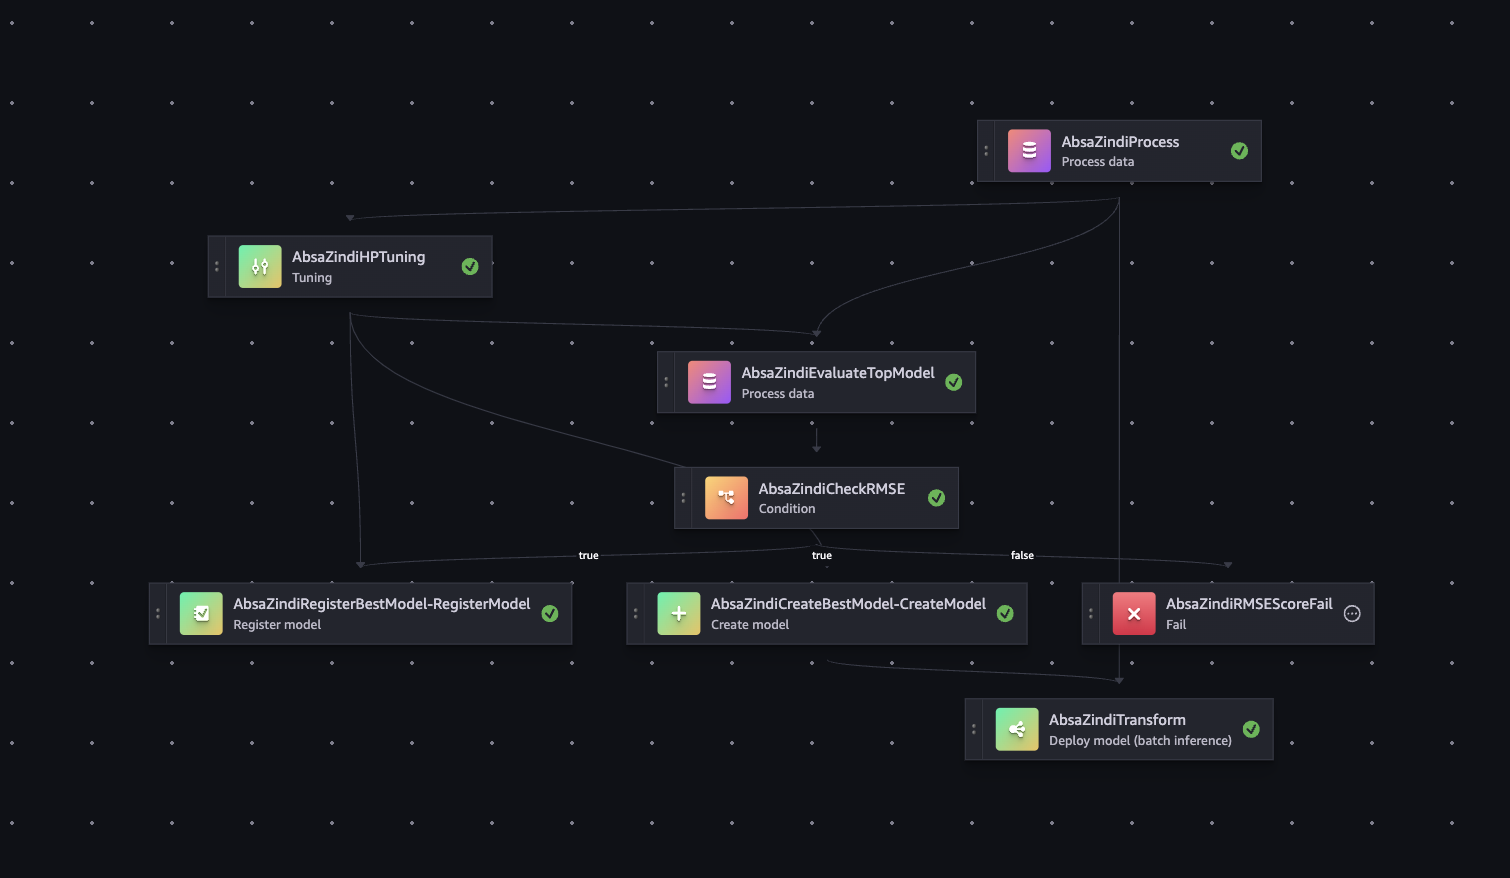

# Useful resources

https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-pipelines/tabular/tuning-step/sagemaker-pipelines-tuning-step.ipynb

https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-python-sdk/scikit_learn_randomforest/Sklearn_on_SageMaker_end2end.html

https://github.com/aws-samples/mlops-pipeline-prestodb/blob/main/0_model_training_pipeline.ipynb

https://github.com/aws/amazon-sagemaker-examples/issues/1207

https://github.com/aws/sagemaker-python-sdk/issues/3932

https://gmoein.github.io/files/Amazon%20SageMaker.pdf

https://github.com/aws/amazon-sagemaker-examples/issues/1920

https://medium.com/@786sksujanislam786/bring-your-own-sklearn-algorithm-in-sagemaker-fe573784926e

https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps-types.html

https://github.com/aws/sagemaker-inference-toolkit/blob/master/README.md

https://github.com/RamVegiraju/Pre-Trained-Sklearn-SageMaker/blob/master/main.py

https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark

https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_processing/spark_distributed_data_processing/sagemaker-spark-processing.html